In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
train_data = pd.read_csv("../../input/titanic/train.csv")
test_data = pd.read_csv("../../input/titanic/test.csv")

In [3]:
train_data.isnull().any()
test_data.isnull().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool

In [4]:
# 把空白的 Age填上 mean
train_data["Age"]=train_data["Age"].fillna(train_data["Age"].mean())
test_data["Age"]=test_data["Age"].fillna(test_data["Age"].mean())

In [5]:
# 把空白的 Fare填上 median
test_data["Fare"]=test_data["Fare"].fillna(test_data["Fare"].median())

In [6]:
train_data.describe().round(2)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,891.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,13.00,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,22.00,0.00,0.00,7.91
50%,446.00,0.00,3.00,29.70,0.00,0.00,14.45
75%,668.50,1.00,3.00,35.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


In [7]:
# 計算生存/死亡人數
from collections import Counter
counter=Counter(train_data["Survived"])
counter

Counter({0: 549, 1: 342})

In [8]:
# Groupby()及pivot_table()函數檢視存活率與特徵之間的關係
train_data.groupby("Sex")[["Survived"]].mean().round(4)

,Survived
Sex,
female,0.7420
male,0.1889


In [9]:
train_data.pivot_table("Survived",index="Sex",columns="Pclass").round(4)

Pclass,1,2,3
Sex,,,
female,0.9681,0.9211,0.5000
male,0.3689,0.1574,0.1354


In [10]:
age=pd.cut(train_data["Age"],[0,18,80])
train_data.pivot_table("Survived",index=["Sex",age],columns="Pclass").round(4)

Pclass                1       2       3
Sex    Age                             
female (0, 18]   0.9091  1.0000  0.5116
       (18, 80]  0.9759  0.9032  0.4950
male   (0, 18]   0.8000  0.6000  0.2157
       (18, 80]  0.3504  0.0860  0.1216

In [11]:
fare=pd.cut(train_data["Fare"],[0,50,100,600])
train_data.pivot_table("Survived",index=[fare],columns="Pclass")

Pclass,1,2,3
Fare,,,
"(0, 50]",0.472222,0.497076,0.238901
"(50, 100]",0.732558,0.285714,0.357143
"(100, 600]",0.735849,NaN,NaN


In [12]:
train_data.pivot_table("Survived",index=[fare,"Sex"],columns="Pclass").round(4)

Pclass                  1       2       3
Fare       Sex                           
(0, 50]    female  0.9167  0.9189  0.5106
           male    0.3833  0.1753  0.1235
(50, 100]  female  1.0000  1.0000  0.0000
           male    0.3947  0.0000  0.4545
(100, 600] female  0.9412     NaN     NaN
           male    0.3684     NaN     NaN

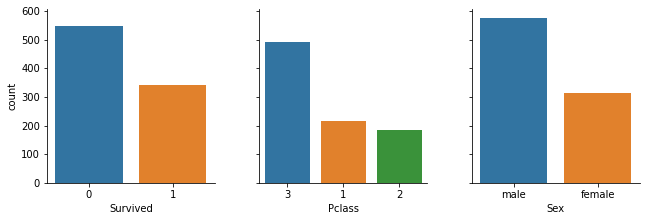

In [13]:
# 存活、艙別、性別的人數長條圖
x_vars=["Survived","Pclass","Sex"]
g = sns.FacetGrid(pd.DataFrame(x_vars), col=0, col_wrap=3, sharex=False)
for ax, x_var in zip(g.axes, x_vars):
    sns.countplot(x=train_data[x_var],order=train_data[x_var].value_counts(ascending=False).index,ax=ax)

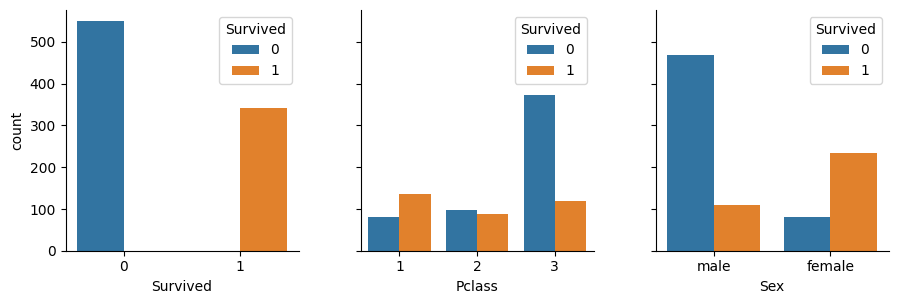

In [14]:
# 艙別、性別的存活人數長條圖
x_vars=["Survived","Pclass","Sex"]
g = sns.FacetGrid(pd.DataFrame(x_vars), col=0, col_wrap=3, sharex=False)
for ax, x_var in zip(g.axes, x_vars):
    sns.countplot(data = train_data, x=train_data[x_var],hue = 'Survived', ax=ax)

In [15]:
# 把 male設為 1，female 設為 2
train_data["Sex"]=train_data["Sex"].map({"male":1,"female":2}).astype(int)
test_data["Sex"]=test_data["Sex"].map({"male":1,"female":2}).astype(int)

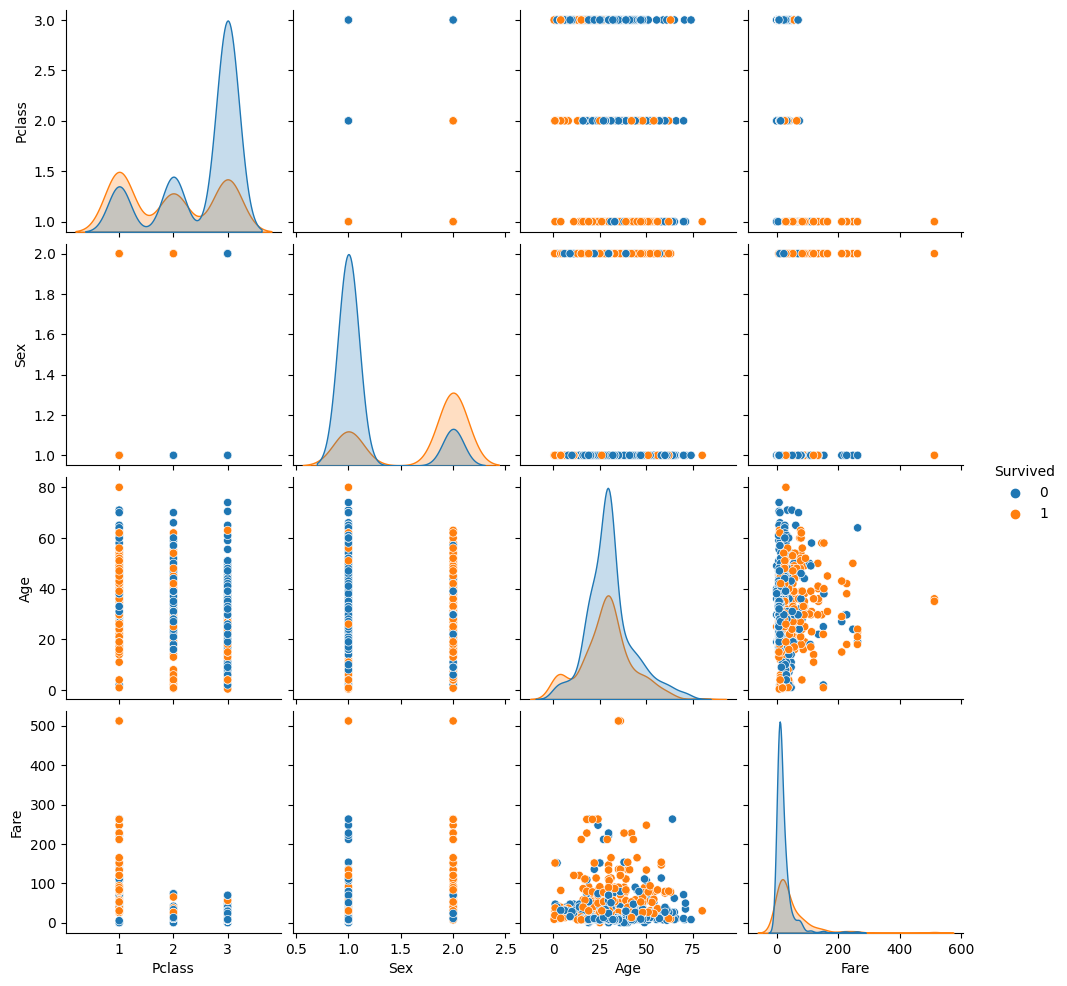

In [16]:
# 數值間的相關性
sns.pairplot(train_data[["Survived","Pclass","Sex","Age","Fare"]],hue="Survived",height=2.5)

In [17]:
# 隨機森林分類/使用train_test_split
predictors=["Pclass","Age","Sex","Fare"]
Xtrain, Xtest, ytrain, ytest = train_test_split(train_data[predictors],train_data["Survived"],random_state=0,test_size=0.2)
model=RandomForestClassifier(n_estimators=100,random_state=0,oob_score=True,min_samples_split=4,max_depth=8)
model.fit(Xtrain,ytrain)
pred1 = model.predict(Xtest)
print("accuracy score: {}".format((accuracy_score(ytest,pred1).round(4)*100)),"%")
print("OOB score: {}".format((model.oob_score_).round(4)*100),"%")

accuracy score: 84.92 %
OOB score: 83.57 %


In [18]:
# 把 test data 套入模型
model.fit(train_data[predictors],train_data["Survived"])
pred=model.predict(test_data[predictors])
print("OOB score: {}".format((model.oob_score_).round(5)*100),"%")

OOB score: 84.512 %


In [ ]:
submission=pd.DataFrame({"PassengerId":test_data["PassengerId"],"Survived":pred})
submission.to_csv('submission.csv', index=False)